### Description
---

This notebook is for testing the use of geopandas to draw polygons and subset data by geographical regions using the polygons.

These efforts will hopefully lead to a method of subsetting float and drifter data by polygons delineating areas of interest.

Links that have inspired this crusade:
- https://stackoverflow.com/a/55658813
- https://gis.stackexchange.com/a/282688
- https://geopandas.org/gallery/create_geopandas_from_pandas.html
- https://geopandas.org/gallery/overlays.html

An alternative method worth looking at:
- https://stackoverflow.com/a/43897516

In [1]:
# import glob
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.wkt import loads
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import stats
import cmocean.cm as cmo
import cmcrameri.cm as cmc
import seawater
import gsw

In [2]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

## Testing polygon creation

In [3]:
# Define polygons for Areas Of Interest

moz = {'poly_id':[1], 'wkt':['POLYGON ((45.359 -25.643, 31.743 -25.643, 37.835 -11.606, 49.313 -11.606, 45.359 -25.643))']}
agu = {'poly_id':[1], 'wkt':['POLYGON ((32.309 -27.922, 33.313 -28.603, 28.009 -35.339, 19.123 -39.747, 19.123 -35.912, 23.459 -34.909, 32.309 -27.922))']}
ben = {'poly_id':[1], 'wkt':['POLYGON ((19.430 -34.749, 14.753 -34.749, 7.164 -16.923, 12.454 -16.923, 19.430 -34.749))']}

# moz = {'poly_id':[1], 'wkt':['POLYGON ((45.359 -27.643, 31.743 -27.643, 37.835 -13.0, 49.313 -13.0, 45.359 -27.643))']}
# agu = {'poly_id':[1], 'wkt':['POLYGON ((33.313 -28.603, 26.0 -38.0, 45.0 -38.0, 45.0 -28.603, 33.313 -28.603))']}
# ben = {'poly_id':[1], 'wkt':['POLYGON ((20.0 -34.749, 12.753 -34.749, 9.164 -20.0, 14.454 -20.0, 20.0 -34.749))']}

# Moz polgon
df_moz = pd.DataFrame( data=moz )
geometry = [loads(pgon) for pgon in df_moz.wkt]
polygon_moz = gpd.GeoDataFrame(df_moz, \
                   crs={'init': 'epsg:4326'}, \
                   geometry=geometry)

# Agu polgon
df_agu = pd.DataFrame( data=agu )
geometry = [loads(pgon) for pgon in df_agu.wkt]
polygon_agu = gpd.GeoDataFrame(df_agu, \
                   crs={'init': 'epsg:4326'}, \
                   geometry=geometry)

# Ben polgon
df_ben = pd.DataFrame( data=ben )
geometry = [loads(pgon) for pgon in df_ben.wkt]
polygon_ben = gpd.GeoDataFrame(df_ben, \
                   crs={'init': 'epsg:4326'}, \
                   geometry=geometry)

## Testing plotting of polygons with world map

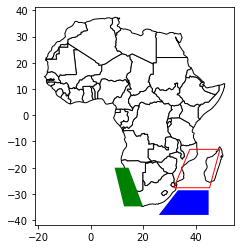

In [66]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to Africa.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
polygon_moz.plot(ax=ax, edgecolor='red', facecolor='None')
polygon_agu.plot(ax=ax, color='blue')
polygon_ben.plot(ax=ax, color='green')

plt.show()

## Clipping polygon to land boundaries

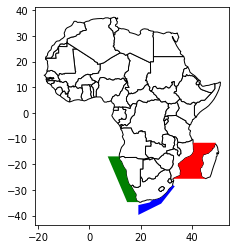

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Clipping polygons to land borders
moz_clipped = gpd.tools.overlay(polygon_moz, world, how="difference")
agu_clipped = gpd.tools.overlay(polygon_agu, world, how="difference")
ben_clipped = gpd.tools.overlay(polygon_ben, world, how="difference")

# We restrict to Africa.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
moz_clipped.plot(ax=ax, color='red')
agu_clipped.plot(ax=ax, color='blue')
ben_clipped.plot(ax=ax, color='green')

# plt.savefig('../Figures/region_polygons.png', dpi=300, bbox_inches='tight')
plt.show()

## Plotting ROIs over RRMSE, OSTIA - CCI

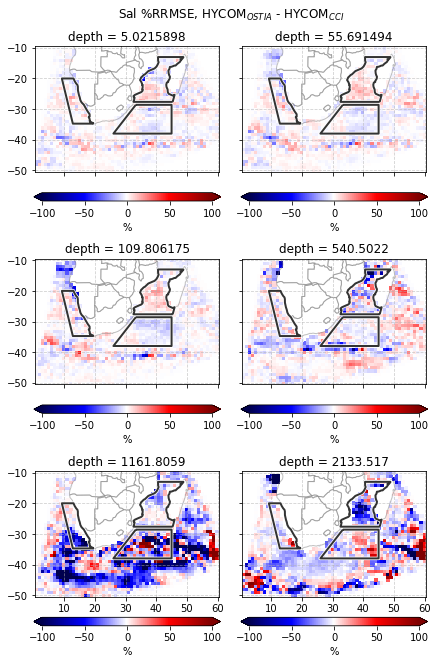

In [139]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
rrmse_temp = xr.open_dataset('../Data/OSTIA_CCI_temp_RRMSE.nc')
rrmse_sal = xr.open_dataset('../Data/OSTIA_CCI_sal_RRMSE.nc')

depth_labels = ['5 m', '55 m', '110 m', '540 m', '1160 m', '2000 m']
depths = [0, 5, 10, 22, 26, 30]

fig, axs = plt.subplots(3, 2, figsize=(7.5,9), sharex=True, sharey=True, tight_layout=True)
axs = axs.flatten()
fig.suptitle('Sal %RRMSE, HYCOM$_{OSTIA}$ - HYCOM$_{CCI}$', y=1.02)

for s, i in enumerate(depth_labels):
    # We restrict to Africa.
    world[world.continent == 'Africa'].plot(ax=axs[s], edgecolor='grey',
                                            facecolor='None', zorder=1, alpha=0.5)
    
    # Select layer. temp or sal
#     layer = rrmse_temp['temperature'][depths[s]]
    layer = rrmse_sal['salinity'][depths[s]]

    img = layer.plot(ax=axs[s], cmap=plt.get_cmap('seismic'),
                     add_colorbar=False, vmin=-100, vmax=100, zorder=0)
    cbar = plt.colorbar(img, ax=axs[s], shrink=0.6, extend='both',
                        orientation='horizontal', pad=0.12)
    cbar.set_label('%')
    
    # Plotting old ROIs.
    moz_clipped.plot(ax=axs[s], edgecolor='k', facecolor='None',
                     linewidth=2.0, alpha=0.8, zorder=3)
    moz_clipped.plot(ax=axs[s], edgecolor='white', facecolor='None',
                     linewidth=3.5, zorder=2)
    agu_clipped.plot(ax=axs[s], edgecolor='k', facecolor='None',
                     linewidth=2.0, alpha=0.8, zorder=3)
    agu_clipped.plot(ax=axs[s], edgecolor='white', facecolor='None',
                     linewidth=3.5, zorder=2)
    ben_clipped.plot(ax=axs[s], edgecolor='k', facecolor='None',
                     linewidth=2.0, alpha=0.8, zorder=3)
    ben_clipped.plot(ax=axs[s], edgecolor='white', facecolor='None',
                     linewidth=3.5, zorder=2)
    
    axs[s].set_ylabel('')
    axs[s].set_xlabel('')
    axs[s].grid(linestyle='--', alpha=0.6)

# plt.savefig('../Figures/ROIs_salRRMSE_new.png', dpi=300, bbox_inches='tight')
plt.show()

## Importing profiles data and plotting

In [5]:
# profs = pd.read_csv('SA_EN4_profiles.csv') # 1 month
# profs = pd.read_csv('SA_EN4_profiles_9.csv') # 9 months
# profs = pd.read_csv('EN4_profiles_200901_200909.csv') # 9 months as read on Fram (different order)
profs = pd.read_csv('EN4_profiles_200901_201203.csv') # 9 months as read on Fram (different order)
profs

,N_PROF,N_LEVELS,LATITUDE,LONGITUDE,DEPH_CORRECTED,POTM_CORRECTED,PSAL_CORRECTED,PSAL_CORRECTED_QC,POTM_CORRECTED_QC,JULD
0,21,0,-43.943001,10.397,4.959837,7.932509,34.20975,1,1,2009-01-01 13:34:46.000017
1,21,1,-43.943001,10.397,9.919554,7.850023,34.21838,1,1,2009-01-01 13:34:46.000017
2,21,2,-43.943001,10.397,14.879150,7.832536,34.22143,1,1,2009-01-01 13:34:46.000017
3,21,3,-43.943001,10.397,19.838627,7.812050,34.22523,1,1,2009-01-01 13:34:46.000017
4,21,4,-43.943001,10.397,24.797983,7.695584,34.23618,1,1,2009-01-01 13:34:46.000017
...,...,...,...,...,...,...,...,...,...,...
3919812,1387575,390,-35.638000,17.447,821.908800,4.037186,NaN,4,1,2012-03-02 09:55:48.000000
3919813,1387575,391,-35.638000,17.447,832.401700,4.036281,NaN,4,1,2012-03-02 09:55:48.000000
3919814,1387575,392,-35.638000,17.447,842.990840,4.075092,NaN,4,1,2012-03-02 09:55:48.000000
3919815,1387575,393,-35.638000,17.447,853.483640,4.054318,NaN,4,1,2012-03-02 09:55:48.000000


In [6]:
# Converting profiles to geopandas dataframe
prof_locs = gpd.GeoDataFrame(profs, crs={'init': 'epsg:4326'})
locs_geom = gpd.points_from_xy(prof_locs.LONGITUDE, prof_locs.LATITUDE)
prof_locs['wkt'] = prof_locs.apply( lambda x: Point(x.LONGITUDE, x.LATITUDE), axis=1 )
prof_locs = gpd.GeoDataFrame(prof_locs, crs={'init': 'epsg:4326'}, \
    geometry=prof_locs['wkt'])

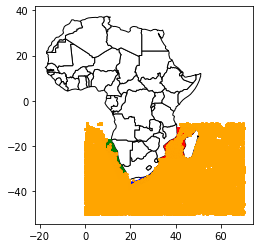

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Showing the whole world
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
moz_clipped.plot(ax=ax, color='red')
agu_clipped.plot(ax=ax, color='blue')
ben_clipped.plot(ax=ax, color='green')
prof_locs.plot(ax=ax, color='orange', markersize=0.5)

# plt.savefig('../Figures/region_polygons_wProfiles.png', dpi=300, bbox_inches='tight')
plt.show()

## Clipping profiles to polygon

In [7]:
profs_moz = gpd.sjoin(prof_locs, moz_clipped, op='within', how='inner')
profs_moz = profs_moz.set_index('N_PROF')
profs_agu = gpd.sjoin(prof_locs, agu_clipped, op='within', how='inner')
profs_agu = profs_agu.set_index('N_PROF')
profs_ben = gpd.sjoin(prof_locs, ben_clipped, op='within', how='inner')
profs_ben = profs_ben.set_index('N_PROF')

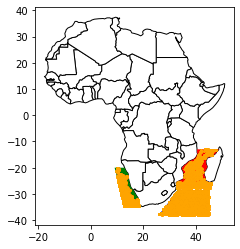

In [94]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Showing the whole world
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
moz_clipped.plot(ax=ax, color='red')
profs_moz.plot(ax=ax, color='orange', markersize=0.5)
agu_clipped.plot(ax=ax, color='blue')
profs_agu.plot(ax=ax, color='orange', markersize=0.5)
ben_clipped.plot(ax=ax, color='green')
profs_ben.plot(ax=ax, color='orange', markersize=0.5)

plt.savefig('../Figures/region_polygons_wProfiles_clipped_ROIv2.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
def match_profiles(region, experiment):
    '''Returns a pandas DataFrame with hycom and EN4 profiles matched for
    specified region and experiment, making it easy to plot correlations.
    
    e.g. ben_corr = match_profiles('ben', 'FREE')
    '''
    if region == 'moz':
        profs = profs_moz
        prof_list = profs_moz.index.unique()
    elif region == 'agu':
        profs = profs_agu
        prof_list = profs_agu.index.unique()
    elif region == 'ben':
        profs = profs_ben
        prof_list = profs_ben.index.unique()
    else:
        print("Unrecognised region, '{0}'. Quitting.".format(region))
        return
    
    print('Matching profiles for {0}...'.format(region))
    
    matched_profs = pd.DataFrame()

    for ID in prof_list:
#         print(ID)
        date = pd.to_datetime(profs.loc[ID]['JULD'].iloc[0])
        doy = date.dayofyear - 1
        year = date.year
        hycom_prof = xr.open_dataset('../Data/EN4_profiles/hycom_profiles/{0}/AGUDAILY_hyc2stations_{1}.{2}_{3:03}.nc'.format(experiment, ID, year, doy))
        hycom_prof = hycom_prof.to_dataframe()
        hycom_prof = hycom_prof.reset_index()
        
        en4_prof = profs.loc[ID]
        en4_prof = en4_prof.reset_index()
        
        matched_dataframe = en4_prof.join(hycom_prof, how='inner')
        matched_profs = matched_profs.append(matched_dataframe)
        
    # add season to each profile
    # https://github.com/pandas-dev/pandas/issues/7454
    # https://stackoverflow.com/a/50857287
    seasons = np.array(['DJF', 'MAM', 'JJA', 'SON'])
    matched_profs['season'] = seasons[(pd.DatetimeIndex(matched_profs['JULD']).month // 3) % 4]
    
    return matched_profs
    print('Completed.')

In [20]:
moz_matched_free = match_profiles('moz','FREE')
moz_matched_cci = match_profiles('moz','CCI')
moz_matched_ostia = match_profiles('moz','OSTIA')
agu_matched_free = match_profiles('agu','FREE')
agu_matched_cci = match_profiles('agu','CCI')
agu_matched_ostia = match_profiles('agu','OSTIA')
ben_matched_free = match_profiles('ben','FREE')
ben_matched_cci = match_profiles('ben','CCI')
ben_matched_ostia = match_profiles('ben','OSTIA')

Matching profiles for moz...


In [20]:
pd.set_option('display.float_format', lambda x: '%.5f' % x) # suppress scientific notation

# prof_unique = moz_matched_ostia['N_PROF'].unique()
# prof_unique
# moz_matched_ostia.loc[prof_unique[0]]['DEPH_CORRECTED'].values
# moz_matched_ostia.loc[prof_unique[0]]
test = moz_matched_ostia.loc[moz_matched_ostia['N_PROF'] == prof_unique[0]]
test

pres = gsw.p_from_z(-test['DEPH_CORRECTED'].to_numpy(), test['LATITUDE'].to_numpy(), geo_strf_dyn_height=0, sea_surface_geopotential=0)
abs_sal = gsw.SA_from_SP(test['PSAL_CORRECTED'].to_numpy(), pres, test['LONGITUDE'].to_numpy(), test['LATITUDE'].to_numpy())
sal_diff = abs_sal - test['PSAL_CORRECTED'].to_numpy()
# sal_diff

# HYCOM pressure in pascal, so divide by 10000 to get dbar.
pres_diff = pres - test['pres']/10000
pres_diff

# deptest = test['DEPH_CORRECTED'] - test['pres']/10000
# deptest

# gsw.CT_from_t(abs_sal, test['POTM_CORRECTED'].to_numpy(), pres)

# test['pres'].to_numpy()

0      -1.67295
1      -2.02603
2      -6.96222
3     -11.29613
4     -14.63271
5     -17.08285
6     -18.34776
7     -18.64331
8     -16.16089
9      -9.69689
10      0.31231
11     -7.53727
12    -11.58795
13    -10.49733
14     -6.54045
15     -1.65225
16     -8.81048
17    -21.68379
18    -30.08047
19    -34.01760
20    -33.44608
21    -28.27014
22    -18.79485
23     -7.40286
24     -9.25152
25    -20.91480
26    -22.99802
27    -17.43342
28    -17.28870
29    -33.61245
30    -55.49138
31    -68.75084
32    -60.46278
33    -29.83428
34    -14.28179
35    -18.37283
36    -31.30963
37     -5.86257
38    -20.26251
39    -27.98354
40      6.62028
41    -76.13179
42   -110.72334
43    -96.78709
44    -91.84192
Name: pres, dtype: float64

In [14]:
type(pres_diff)

pandas.core.series.Series

In [60]:
def plot_profiles(region, experiment):
    '''Plot scatter plots of temperature and salinity between hycom
    and EN4 profiles and calculate and display the correlation.
    
    e.g. plot_profiles('moz', 'FREE')
    '''
    if region == 'moz' and experiment == 'FREE':
        profs = moz_matched_free.copy()
        reg_name = 'Mozambique'
    elif region == 'moz' and experiment == 'CCI':
        profs = moz_matched_cci.copy()
        reg_name = 'Mozambique'
    elif region == 'moz' and experiment == 'OSTIA':
        profs = moz_matched_ostia.copy()
        reg_name = 'Mozambique'
    elif region == 'agu' and experiment == 'FREE':
        profs = agu_matched_free.copy()
        reg_name = 'Agulhas'
    elif region == 'agu' and experiment == 'CCI':
        profs = agu_matched_cci.copy()
        reg_name = 'Agulhas'
    elif region == 'agu' and experiment == 'OSTIA':
        profs = agu_matched_ostia.copy()
        reg_name = 'Agulhas'
    elif region == 'ben' and experiment == 'FREE':
        profs = ben_matched_free.copy()
        reg_name = 'Benguela'
    elif region == 'ben' and experiment == 'CCI':
        profs = ben_matched_cci.copy()
        reg_name = 'Benguela'
    elif region == 'ben' and experiment == 'OSTIA':
        profs = ben_matched_ostia.copy()
        reg_name = 'Benguela'
    else:
        print("Unrecognised region, '{0}', or experiment \
              '{1}'.Quitting.".format(region, experiment))
        return
    
    fig, axs = plt.subplots(1, 2, figsize=(6,3.5))
    plt.suptitle('HYCOM$_{{{0}}}$ vs EN4 profiles, {1}'.format(experiment, reg_name),
                y = 1.02)
    
    # Temperature
    im = axs[0].scatter(profs['POTM_CORRECTED'], profs['temperature'],
                        c=profs['depth'], cmap=cmo.deep, s=0.8, vmin=0, vmax=2000)
    cbar = plt.colorbar(im, ax=axs[0], shrink=0.8, extend='neither',
                        orientation='horizontal', pad=0.18)
    cbar.set_label('depth (m)')
    axs[0].set_ylabel('HYCOM temperature ($^{\circ}$C)')
    axs[0].set_xlabel('EN4 temperature ($^{\circ}$C)')
    axs[0].set_ylim(0,35)
    axs[0].set_xlim(0,35)
    axs[0].set_yticks([0,5,10,15,20,25,30,35])
    axs[0].set_xticks([0,5,10,15,20,25,30,35])
    axs[0].grid(linestyle='dashed',alpha=0.4)
    
    # Plot regresssion line
    nanmask = (~np.isnan(profs['POTM_CORRECTED']) & 
               ~np.isnan(profs['temperature']))
    (slope, intercept, r_value, p_value,
     std_err) = stats.linregress(profs['POTM_CORRECTED'][nanmask],
                                 profs['temperature'][nanmask])
    print(slope, intercept, r_value, p_value, std_err)
    line = slope * profs['POTM_CORRECTED'] + intercept
    im2 = axs[0].plot(profs['POTM_CORRECTED'], line, 'r',
                      label='y={0:.2f}x+{1:.2f}'.format(slope,intercept))
    
    # add correlation calculation here
    temp_corr = profs['POTM_CORRECTED'].corr(profs['temperature'])
    axs[0].text(0.07, 0.93, 'Correlation = {0}'.format(round((temp_corr),3)),
                fontweight='roman', horizontalalignment='left',
                verticalalignment='center', transform=axs[0].transAxes)
#     axs[0].text(0.07, 0.86, 'p-value = {0}'.format(round((p_value),3)), fontweight='roman', horizontalalignment='left', verticalalignment='center', transform=axs[0].transAxes)
    axs[0].legend(loc='lower right', fontsize='small')
    axs[0].set_title('Temperature', fontsize='medium')
    
    # Salinity
    im = axs[1].scatter(profs['PSAL_CORRECTED'], profs['salinity'],
                        c=profs['depth'], cmap=cmo.deep,
                        s=0.8, vmin=0, vmax=2000)
    cbar = plt.colorbar(im, ax=axs[1], shrink=0.8, extend='neither',
                        orientation='horizontal', pad=0.18)
    cbar.set_label('depth (m)')
    axs[1].set_ylabel('HYCOM salinity')
    axs[1].set_xlabel('EN4 salinity')
    axs[1].set_ylim(34.0,36.0)
    axs[1].set_xlim(34.0,36.0)
    axs[1].set_yticks([34.0,34.5,35.0,35.5])
    axs[1].set_xticks([34.0,34.5,35.0,35.5])
    axs[1].grid(linestyle='dashed',alpha=0.4)
    
    # Plot regresssion line
    nanmask = (~np.isnan(profs['PSAL_CORRECTED']) &
               ~np.isnan(profs['salinity']))
    (slope, intercept, r_value, p_value,
     std_err) = stats.linregress(profs['PSAL_CORRECTED'][nanmask],
                                 profs['salinity'][nanmask])
    print(slope, intercept, r_value, p_value, std_err)
    line = slope * profs['PSAL_CORRECTED'] + intercept
    im2 = axs[1].plot(profs['PSAL_CORRECTED'], line, 'r',
                      label='y={0:.2f}x+{1:.2f}'.format(slope,intercept))
    
    # add correlation calculation here
    sal_corr = profs['PSAL_CORRECTED'].corr(profs['salinity'])
    axs[1].text(0.07, 0.93, 'Correlation = {0}'.format(round((sal_corr),3)),
                fontweight='roman', horizontalalignment='left',
                verticalalignment='center', transform=axs[1].transAxes)
#     axs[1].text(0.07, 0.86, 'p-value = {0}'.format(round((p_value),3)), fontweight='roman', horizontalalignment='left', verticalalignment='center', transform=axs[1].transAxes)
    axs[1].legend(loc='lower right', fontsize='small')
    axs[1].set_title('Salinity', fontsize='medium')
        
    fig.tight_layout()
    fig.savefig('../Figures/profiles/EN4_profile_data/Profile_scatterplots_{0}_{1}.png'.format(region,experiment),
                dpi=300, bbox_inches='tight')

0.9769254030343186 0.45299348912022985 0.9683597420904747 0.0 0.0006797882976971414
0.6836381762196496 11.017060655856138 0.9432239636313381 0.0 0.0010805476744562173


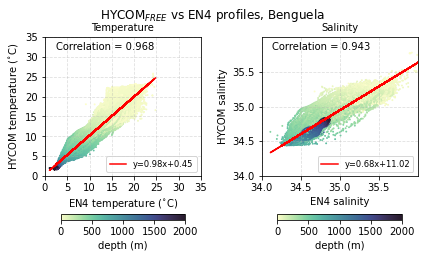

In [73]:
plot_profiles('ben', 'FREE')

0.9389392220379812 0.5956100064111087 0.9170878736095501 0.0 0.0016810819248997654
0.6418682835310107 12.48792821198083 0.8551766909153006 0.0 0.002194505394653627


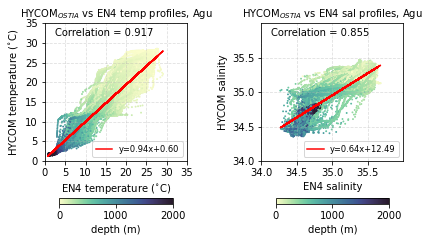

In [41]:
plot_profiles(agu_matched_cci, 'Agu', 'OSTIA')

0.9769254030343186 0.45299348912022985 0.9683597420904747 0.0 0.0006797882976971414
0.6836381762196496 11.017060655856138 0.9432239636313381 0.0 0.0010805476744562173


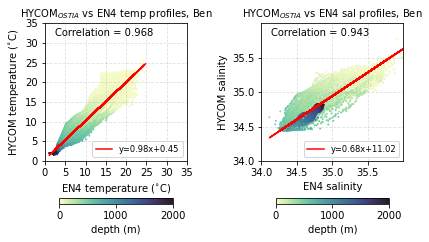

In [42]:
plot_profiles(ben_matched_free, 'Ben', 'OSTIA')

## Plot T-S Diagrams

In [71]:
def ts_plot(experiment):
    '''Plot T-S diagrams for all 3 regions of interest for defined experiment/obs.
    
    e.g. ts_plot('FREE')
    '''
    if experiment == 'EN4':
        profs_moz = moz_matched_free.copy()
        profs_agu = agu_matched_free.copy()
        profs_ben = ben_matched_free.copy()
        temp_var = 'POTM_CORRECTED'
        sal_var = 'PSAL_CORRECTED'
    elif experiment == 'FREE':
        profs_moz = moz_matched_free.copy()
        profs_agu = agu_matched_free.copy()
        profs_ben = ben_matched_free.copy()
        temp_var = 'temperature'
        sal_var = 'salinity'
    elif experiment == 'CCI':
        profs_moz = moz_matched_cci.copy()
        profs_agu = agu_matched_cci.copy()
        profs_ben = ben_matched_cci.copy()
        temp_var = 'temperature'
        sal_var = 'salinity'
    elif experiment == 'OSTIA':
        profs_moz = moz_matched_ostia.copy()
        profs_agu = agu_matched_ostia.copy()
        profs_ben = ben_matched_ostia.copy()
        temp_var = 'temperature'
        sal_var = 'salinity'
#     elif experiment == 'L2':
#         profs_moz = moz_matched_l2.copy()
#         profs_agu = agu_matched_l2.copy()
#         profs_ben = ben_matched_l2.copy()
#     elif experiment == 'L2L3':
#         profs_moz = moz_matched_l2l3.copy()
#         profs_agu = agu_matched_l2l3.copy()
#         profs_ben = ben_matched_l2l3.copy()
    else:
        print("Unrecognised experiment, '{0}'. Quitting.".format(experiment))
        return
    
    fig, axs = plt.subplots(1, 3, figsize=(6.5,4), sharey=True)
    
    # Calculate the density lines
    x = np.arange(33, 37, .1)
    y = np.arange(-2, 33, .5)
    X, Y = np.meshgrid(x, y)
    Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t
    
    # Plot Moz region
    CS = axs[0].contour(X, Y, Z, colors='grey', linestyles='dashed',
                        levels=np.arange(21,30,.5), alpha=0.6)
    axs[0].clabel(CS, inline=1, fontsize=8, fmt='%0.1f')

    # Plot the data
    im = axs[0].scatter(profs_moz[sal_var], profs_moz[temp_var],
                        c=profs_moz['depth'], cmap=cmo.haline_r, vmin=0, vmax=2000)
    cbar = plt.colorbar(im, ax=axs[0], shrink=0.8, extend='neither',
                        orientation='horizontal', pad=0.15)
    cbar.set_label('Depth (m)')
    axs[0].set_xlim(33.5,36.5)
    axs[0].set_ylim(-2,32)
    axs[0].set_xlabel('Salinity')
    axs[0].set_ylabel('Temperature ($^{\circ}$C)')
    axs[0].set_title('Mozambique')
    
    #-----------------------------------------------------------------------------
    
    # Plot Agu region
    CS = axs[1].contour(X, Y, Z, colors='grey', linestyles='dashed',
                        levels=np.arange(21,30,.5), alpha=0.6)
    axs[1].clabel(CS, inline=1, fontsize=8, fmt='%0.1f')

    # Plot the data
    im = axs[1].scatter(profs_agu[sal_var], profs_agu[temp_var],
                        c=profs_agu['depth'], cmap=cmo.haline_r, vmin=0, vmax=2000)
    cbar = plt.colorbar(im, ax=axs[1], shrink=0.8, extend='neither',
                        orientation='horizontal', pad=0.15)
    cbar.set_label('Depth (m)')
    axs[1].set_xlim(33.5,36.5)
    axs[1].set_ylim(-2,32)
    axs[1].set_xlabel('Salinity')
    axs[1].set_title('Agulhas')
    
    #-----------------------------------------------------------------------------
    
    # Plot Ben region
    CS = axs[2].contour(X, Y, Z, colors='grey', linestyles='dashed',
                        levels=np.arange(21,30,.5), alpha=0.6)
    axs[2].clabel(CS, inline=1, fontsize=8, fmt='%0.1f')

    # Plot the data
    im = axs[2].scatter(profs_ben[sal_var], profs_ben[temp_var],
                        c=profs_ben['depth'], cmap=cmo.haline_r, vmin=0, vmax=2000)
    cbar = plt.colorbar(im, ax=axs[2], shrink=0.8, extend='neither',
                        orientation='horizontal', pad=0.15)
    cbar.set_label('Depth (m)')
    axs[2].set_xlim(33.5,36.5)
    axs[2].set_ylim(-2,32)
    axs[2].set_xlabel('Salinity')
    axs[2].set_title('Benguela')
    
    plt.tight_layout()
    fig.savefig('../Figures/TS_diagrams/TS_diagrams_{0}_ROIv2.png'.format(experiment),
                dpi=300, bbox_inches='tight')

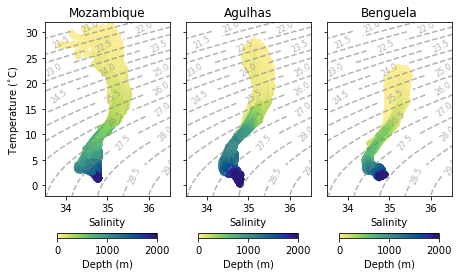

In [75]:
ts_plot('OSTIA')

### Plot comparison T-S

In [76]:
def ts_ComparePlot(region, experiment):
    '''Plot comparative T-S diagrams for both model and EN4 on single plot.
    
    e.g. ts_plot('agu', 'FREE')
    '''
    if region == 'moz' and experiment == 'FREE':
        profs = moz_matched_free.copy()
        reg_name = 'Mozambique'
    elif region == 'moz' and experiment == 'CCI':
        profs = moz_matched_cci.copy()
        reg_name = 'Mozambique'
    elif region == 'moz' and experiment == 'OSTIA':
        profs = moz_matched_ostia.copy()
        reg_name = 'Mozambique'
    elif region == 'agu' and experiment == 'FREE':
        profs = agu_matched_free.copy()
        reg_name = 'Agulhas'
    elif region == 'agu' and experiment == 'CCI':
        profs = agu_matched_cci.copy()
        reg_name = 'Agulhas'
    elif region == 'agu' and experiment == 'OSTIA':
        profs = agu_matched_ostia.copy()
        reg_name = 'Agulhas'
    elif region == 'ben' and experiment == 'FREE':
        profs = ben_matched_free.copy()
        reg_name = 'Benguela'
    elif region == 'ben' and experiment == 'CCI':
        profs = ben_matched_cci.copy()
        reg_name = 'Benguela'
    elif region == 'ben' and experiment == 'OSTIA':
        profs = ben_matched_ostia.copy()
        reg_name = 'Benguela'
    else:
        print("Unrecognised region, '{0}', or experiment \
              '{1}'.Quitting.".format(region, experiment))
        return
    
    fig, axs = plt.subplots(1, 1, figsize=(9,7))
    
    blues_full = plt.cm.get_cmap('Blues', 720)
    blues_clipped = matplotlib.colors.ListedColormap(blues_full(np.linspace(0.35, 1.00, 512)))
    oranges_full = plt.cm.get_cmap('Oranges', 512)
    oranges_clipped = matplotlib.colors.ListedColormap(oranges_full(np.linspace(0.35, 1.00, 512)))
    
    # Calculate the density lines
    x = np.arange(33, 37, .1)
    y = np.arange(-2, 33, .5)
    X, Y = np.meshgrid(x, y)
    Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t
    
    # Plot density
    CS = axs.contour(X, Y, Z, colors='grey', linestyles='dashed',
                        levels=np.arange(21,30,.5), alpha=0.6)
    axs.clabel(CS, inline=1, fontsize=8, fmt='%0.1f')

    # Plot EN4 data
    im_EN4 = axs.scatter(profs['PSAL_CORRECTED'], profs['POTM_CORRECTED'],
                        c=profs['depth'], cmap=blues_clipped, vmin=0, vmax=2000,
                        marker='o', alpha=0.4, label='EN4')
    cbar_EN4 = plt.colorbar(im_EN4, ax=axs, shrink=0.8, extend='neither',
                        orientation='vertical', aspect=30, pad=0.01)
    cbar_EN4.ax.invert_yaxis()
    cbar_EN4.set_label('Depth (m)')
    # Plot HYCOM data
    im_HYC = axs.scatter(profs['salinity'], profs['temperature'],
                        c=profs['depth'], cmap=oranges_clipped, vmin=0, vmax=2000,
                        marker='+', alpha=0.4, label='HYCOM$_{{{0}}}$'.format(experiment))
    cbar_HYC = plt.colorbar(im_HYC, ax=axs, shrink=0.8, extend='neither',
                        orientation='vertical', aspect=30, pad=0.01)
    cbar_HYC.ax.invert_yaxis()
    #     cbar_HYC.set_label('Depth (m)')
    
    axs.legend()
    legend = axs.get_legend()
    legend.legendHandles[0].set_color(plt.cm.Blues(.8))
    legend.legendHandles[1].set_color(plt.cm.Oranges(.8))
    axs.set_xlim(33.5,36.5)
    axs.set_ylim(-2,32)
    axs.set_xlabel('Salinity')
    axs.set_ylabel('Temperature ($^{\circ}$C)')
    axs.set_title('HYCOM$_{{{0}}}$ vs EN4, {1}'.format(experiment, reg_name))
    
    #-----------------------------------------------------------------------------
    
    fig.tight_layout()
    plt.savefig('../Figures/TS_diagrams/TS_Comparison_hycom{0}_EN4_{1}_ROIv2.png'.format(experiment, region), dpi=300, bbox_inches='tight')    

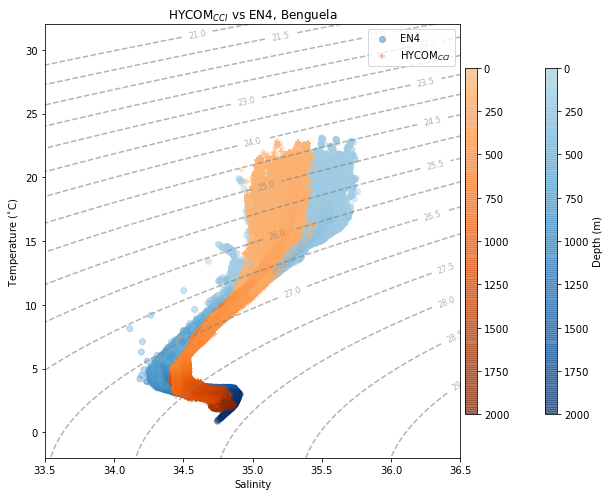

In [85]:
ts_ComparePlot('ben', 'CCI')

AttributeError: 'numpy.ndarray' object has no attribute 'contour'

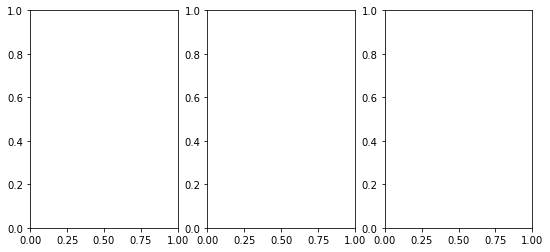

In [58]:
'''
# TS Diagram with density contours
plt.figure(figsize=(8,6))

# Calculate the density lines
x = np.arange(33, 35, .1)
y = np.arange(2, 23, .5)
X, Y = np.meshgrid(x, y)
Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t

# Plot the contour lines
CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.5))
plt.clabel(CS, inline=1, fontsize=10, fmt='%0.1f')

# Plot the data
nprof = 25 #Selected profile
plt.scatter(data.psal_adjusted[nprof], data.temp_adjusted[nprof], c=data.pres_adjusted[nprof], cmap='viridis_r')
plt.xlabel('Salinity');
plt.ylabel('Temperature (°C)')
plt.title('Argo Float #%d on %s' % (data.platform_number[nprof].values, data.juld[nprof].dt.strftime('%Y-%m-%d').values), fontweight='bold');

# Add a colorbar
cbh = plt.colorbar(label='Pressure (dbar)');
'''

fig, axs = plt.subplots(1, 3, figsize=(9,4))

# Calculate the density lines
x = np.arange(33, 37, .1)
y = np.arange(-2, 33, .5)
X, Y = np.meshgrid(x, y)
Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t

# Plot the contour lines
CS = axs.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(21,30,.5))
axs.clabel(CS, inline=1, fontsize=10, fmt='%0.1f')

# Plot the data
# nprof = 25 #Selected profile
im = axs.scatter(moz_matched['PSAL_CORRECTED'], moz_matched['TEMP'], c=moz_matched['depth'], cmap=cmo.haline_r, vmin=0, vmax=2000)
cbar = plt.colorbar(im, ax=axs, shrink=0.8, extend='neither', orientation='horizontal', pad=0.11)
cbar.set_label('Depth (m)')
axs.set_xlim(33.5,36.5)
axs.set_ylim(-2,32)
axs.set_xlabel('Salinity')
axs.set_ylabel('Temperature ($^{\circ}$C)')
# axs.title('Argo Float #%d on %s' % (data.platform_number[nprof].values, data.juld[nprof].dt.strftime('%Y-%m-%d').values), fontweight='bold');

# Add a colorbar


## Plotting profiles statistics

In [94]:
def plotProfileStats(region, experiment):
    '''Plot the mean, standard deviation, and rolling correlation of profiles
    for specified region binned into 50 metre intervals.
    
    Returns plot with 2 rows of 3 subfigures each displaying mean, standard deviation
    and rolling correlation between EN4 reference data, respectively.
    Row 1 is for temperature, row 2 for salinity.
    
    Example usage: plotProfileStats('Agu')
    '''
    if region == 'moz' and experiment == 'FREE':
        profs = moz_matched_free.copy()
    elif region == 'moz' and experiment == 'CCI':
        profs = moz_matched_cci.copy()
    elif region == 'moz' and experiment == 'OSTIA':
        profs = moz_matched_ostia.copy()
    elif region == 'agu' and experiment == 'FREE':
        profs = agu_matched_free.copy()
    elif region == 'agu' and experiment == 'CCI':
        profs = agu_matched_cci.copy()
    elif region == 'agu' and experiment == 'OSTIA':
        profs = agu_matched_ostia.copy()
    elif region == 'ben' and experiment == 'FREE':
        profs = ben_matched_free.copy()
    elif region == 'ben' and experiment == 'CCI':
        profs = ben_matched_cci.copy()
    elif region == 'ben' and experiment == 'OSTIA':
        profs = ben_matched_ostia.copy()
    else:
        print("Unrecognised region, '{0}'. Quitting.".format(region))
        return
    
    # Create absolute differences between model and EN4
    # !!! (not actually used at present) !!!
    profs['diff_temp'] = abs(profs['POTM_CORRECTED'] - profs['temperature'])
    profs['diff_sal'] = abs(profs['PSAL_CORRECTED'] - profs['salinity'])
    
    # Group data by depth intervals and mean values per bin
    binned_profs_mean = profs.groupby(pd.cut(profs['DEPH_CORRECTED'],
                                             np.arange(0, 2050, 50))).mean()
    
    # Get standard deviation by grouping again but rather taking stdev instead of mean
    binned_profs_std = profs.groupby(pd.cut(profs['DEPH_CORRECTED'],
                                            np.arange(0, 2050, 50))).std()
    
    # Get counts by grouping again but rather taking count instead of stdev
    binned_profs_count = profs.groupby(pd.cut(profs['DEPH_CORRECTED'],
                                              np.arange(0, 2050, 50))).count()
    
    # Get rolling correlation by grouping again but rather taking corr instead of mean
    # Technique: https://stackoverflow.com/questions/28988627/pandas-correlation-groupby
    temp_corr_profs = profs.groupby(pd.cut(profs['DEPH_CORRECTED'], np.arange(0, 2050, 50)))[['POTM_CORRECTED','temperature']].corr().iloc[0::2,-1]
    sal_corr_profs = profs.groupby(pd.cut(profs['DEPH_CORRECTED'], np.arange(0, 2050, 50)))[['PSAL_CORRECTED','salinity']].corr().iloc[0::2,-1]
    
    # Now create new columns with the added data
    binned_profs_mean['POTM_std'] = binned_profs_std['POTM_CORRECTED']
    binned_profs_mean['temperature_std'] = binned_profs_std['temperature']
    binned_profs_mean['PSAL_std'] = binned_profs_std['PSAL_CORRECTED']
    binned_profs_mean['salinity_std'] = binned_profs_std['salinity']
    binned_profs_mean['temp_corr'] = temp_corr_profs.values
    binned_profs_mean['sal_corr'] = sal_corr_profs.values
    binned_profs_mean['temp_counts'] = binned_profs_count['POTM_CORRECTED']
    binned_profs_mean['sal_counts'] = binned_profs_count['PSAL_CORRECTED']
    
#     print(binned_profs_mean['temp_counts'])
#     print(type(binned_profs_mean['temp_counts']))
#     print(np.array(binned_profs_mean['temp_counts']))
#     return binned_profs_mean

    # Plotting the statistics
    fig, axs = plt.subplots(2, 3, figsize=(6.5,6), sharey=True)
    fig.suptitle('HYCOM$_{{{0}}}$ vs EN4 profile statistics, {1}'.format(experiment, region), y=1.01)
    
    #--------------------------------------------------------
    # Plotting the first row of subfigures, Temperature
    # Plot mean
    axs[0,0].plot(binned_profs_mean['POTM_CORRECTED'],
                  binned_profs_mean['DEPH_CORRECTED'], label='EN4')
    axs[0,0].plot(binned_profs_mean['temperature'],
                  binned_profs_mean['DEPH_CORRECTED'], label='HYCOM')
    axs[0,0].invert_yaxis()    # only call this once thoughout plotting script !!!
    axs[0,0].set_xlim(-2,28)
    axs[0,0].grid(linestyle='--')
    axs[0,0].set_xlabel('Temperature ($^{\circ}$C)')
    axs[0,0].set_ylabel('Depth (m)')
    axs[0,0].text(0.15, 0.95, 'Temp. mean', fontweight='roman',
                  horizontalalignment='right', verticalalignment='top',
                  rotation='vertical', transform=axs[0,0].transAxes)
    axs[0,0].legend(loc='lower right', fontsize='small')
    axs[0,0].tick_params(axis="both", direction='in', top=True, right=True)
    
    # Plot standard deviation
    axs[0,1].plot(binned_profs_mean['POTM_std'],
                  binned_profs_mean['DEPH_CORRECTED'], label='EN4')
    axs[0,1].plot(binned_profs_mean['temperature_std'],
                  binned_profs_mean['DEPH_CORRECTED'], label='HYCOM')
    axs[0,1].set_xlim(-1,4)
    axs[0,1].grid(linestyle='--')
    axs[0,1].set_xlabel('Temperature ($^{\circ}$C)')
    axs[0,1].text(0.15, 0.95, 'Temp. standard deviation', fontweight='roman',
                  horizontalalignment='right', verticalalignment='top',
                  rotation='vertical', transform=axs[0,1].transAxes)
    axs[0,1].legend(loc='lower right', fontsize='small')
    axs[0,1].tick_params(axis="both", direction='in', top=True, right=True)
    
    # Plot rolling correlation
    axs[0,2].plot(binned_profs_mean['temp_corr'],
                  binned_profs_mean['DEPH_CORRECTED'], c='k')
#     axs[0,2].hist(binned_profs_mean['temp_counts'], 40, orientation='horizontal', normed=True)
    axs[0,2].set_xlim(-1,1)
    axs[0,2].grid(linestyle='--')
    axs[0,2].axvline(x=0, c='k', linewidth=0.8)
    axs[0,2].set_xlabel('Correlation (r)')
    axs[0,2].text(0.15, 0.95, 'Temp. correlation', fontweight='roman',
                  horizontalalignment='right', verticalalignment='top',
                  rotation = 'vertical', transform=axs[0,2].transAxes)
    axs[0,2].set_xticks(ticks=([-1,-0.5,0,0.5,1]))
    axs[0,2].tick_params(axis="both", direction='in', top=True, right=True)
    
    # Add histogram to correlation plot
    axs_twin1 = axs[0,2].twiny()
    axs_twin1.barh(y = binned_profs_mean['DEPH_CORRECTED'],
                   width = binned_profs_mean['temp_counts'], align='center',
                   height=50, color='grey', alpha=0.4)
    axs_twin1.invert_xaxis()
    axs_twin1.set_xlim(2.5 * max(binned_profs_mean['temp_counts']),0)
    axs_twin1.axis('off')
    # following two lines fix z-order
    axs[0,2].set_zorder(axs_twin1.get_zorder()+1)
    axs[0,2].patch.set_visible(False)
    
    #--------------------------------------------------------
    # Plotting the second row of subfigures, Salinity
    # Plot mean
    axs[1,0].plot(binned_profs_mean['PSAL_CORRECTED'],
                  binned_profs_mean['DEPH_CORRECTED'], label='EN4')
    axs[1,0].plot(binned_profs_mean['salinity'],
                  binned_profs_mean['DEPH_CORRECTED'], label='HYCOM')
    axs[1,0].set_xlim(32.5,36.5)
    axs[1,0].grid(linestyle='--')
    axs[1,0].set_xlabel('Salinity')
    axs[1,0].set_ylabel('Depth (m)')
    axs[1,0].text(0.15, 0.95, 'Sal. mean', fontweight='roman',
                  horizontalalignment='right', verticalalignment='top',
                  rotation='vertical', transform=axs[1,0].transAxes)
    axs[1,0].legend(loc='lower left', fontsize='small')
    axs[1,0].tick_params(axis="both", direction='in', top=True, right=True)
    
    # Plot standard deviation
    axs[1,1].plot(binned_profs_mean['PSAL_std'],
                  binned_profs_mean['DEPH_CORRECTED'], label='EN4')
    axs[1,1].plot(binned_profs_mean['salinity_std'],
                  binned_profs_mean['DEPH_CORRECTED'], label='HYCOM')
    axs[1,1].set_xlim(-0.1,0.4)
    axs[1,1].grid(linestyle='--')
    axs[1,1].set_xlabel('Salinity')
    axs[1,1].text(0.15, 0.95, 'Sal. standard deviation', fontweight='roman',
                  horizontalalignment='right', verticalalignment='top',
                  rotation='vertical', transform=axs[1,1].transAxes)
    axs[1,1].legend(loc='lower right', fontsize='small')
    axs[1,1].tick_params(axis="both", direction='in', top=True, right=True)
    
    # Plot rolling correlation
    axs[1,2].plot(binned_profs_mean['sal_corr'],
                  binned_profs_mean['DEPH_CORRECTED'], c='k')
    axs[1,2].set_xlim(-1,1)
    axs[1,2].grid(linestyle='--')
    axs[1,2].axvline(x=0, c='k', linewidth=0.8)
    axs[1,2].set_xlabel('Correlation (r)')
    axs[1,2].set_xlabel('Correlation (r)')
    axs[1,2].text(0.15, 0.95, 'Sal. correlation', fontweight='roman',
                  horizontalalignment='right', verticalalignment='top',
                  rotation = 'vertical', transform=axs[1,2].transAxes)
    axs[1,2].set_xticks(ticks=([-1,-0.5,0,0.5,1]))
    axs[1,2].tick_params(axis="both", direction='in', top=True, right=True)
    
    # Add histogram to correlation plot
#     axs_twin2 = axs[1,2].twiny()
#     axs_twin2.hist(binned_profs_mean['sal_counts'].values, 40, color='grey', alpha=0.6, orientation='horizontal', density=True, histtype='step')
#     axs_twin2.invert_xaxis()
#     axs_twin2.set_xlim(0.03,0)
#     axs_twin2.axis('off')
#     # following two lines fix z-order
#     axs[1,2].set_zorder(axs_twin2.get_zorder()+1)
#     axs[1,2].patch.set_visible(False)
    
    axs_twin2 = axs[1,2].twiny()
    axs_twin2.barh(y = binned_profs_mean['DEPH_CORRECTED'],
                   width = binned_profs_mean['sal_counts'], align='center',
                   height=50, color='grey', alpha=0.4)
    axs_twin2.invert_xaxis()
    axs_twin2.set_xlim(2.5 * max(binned_profs_mean['sal_counts']),0)
    axs_twin2.axis('off')
    # following two lines fix z-order
    axs[1,2].set_zorder(axs_twin2.get_zorder()+1)
    axs[1,2].patch.set_visible(False)
    
    fig.tight_layout()
    plt.savefig('../Figures/profiles/EN4_profile_data/Profile_statistics_hycom{0}_EN4_{1}.png'.format(experiment, region), dpi=300, bbox_inches='tight')    
    

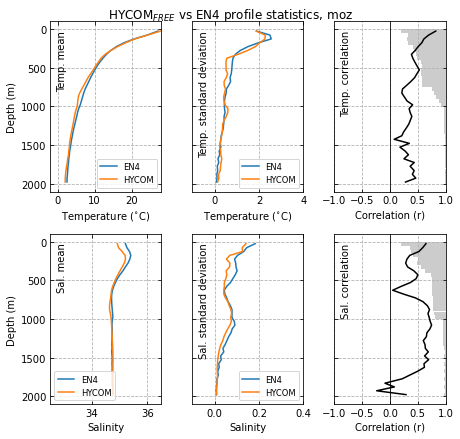

In [103]:
plotProfileStats('moz', 'FREE')

### Adjusting for better interpretablity

After suggestions from supervisors, all experiments will be shown per region and correlations will be removed.

In [86]:
def plotProfileStats(region):
    '''Plot the mean and standard deviation of profiles
    for specified region binned into 50 metre intervals.
    
    Returns plot with 2 rows of 2 subfigures each displaying mean
    and standard deviation against EN4 reference data, respectively.
    Row 1 is for temperature, row 2 for salinity.
    
    Example usage: plotProfileStats('Agu')
    '''
    if region == 'moz':
        profs_free = moz_matched_free.copy()
        profs_cci = moz_matched_cci.copy()
        profs_ostia = moz_matched_ostia.copy()
    elif region == 'agu':
        profs_free = agu_matched_free.copy()
        profs_cci = agu_matched_cci.copy()
        profs_ostia = agu_matched_ostia.copy()
    elif region == 'ben':
        profs_free = ben_matched_free.copy()
        profs_cci = ben_matched_cci.copy()
        profs_ostia = ben_matched_ostia.copy()
    else:
        print("Unrecognised region, '{0}'. Quitting.".format(region))
        return
    
    # Group data by depth intervals and mean values per bin
    binned_profs_mean_free = profs_free.groupby(pd.cut(profs_free['DEPH_CORRECTED'],
                                             np.arange(0, 2050, 50))).mean()
    binned_profs_mean_cci = profs_cci.groupby(pd.cut(profs_cci['DEPH_CORRECTED'],
                                             np.arange(0, 2050, 50))).mean()
    binned_profs_mean_ostia = profs_ostia.groupby(pd.cut(profs_ostia['DEPH_CORRECTED'],
                                             np.arange(0, 2050, 50))).mean()
    
    # Get standard deviation by grouping again but rather taking stdev instead of mean
    binned_profs_std_free = profs_free.groupby(pd.cut(profs_free['DEPH_CORRECTED'],
                                            np.arange(0, 2050, 50))).std()
    binned_profs_std_cci = profs_cci.groupby(pd.cut(profs_cci['DEPH_CORRECTED'],
                                            np.arange(0, 2050, 50))).std()
    binned_profs_std_ostia = profs_ostia.groupby(pd.cut(profs_ostia['DEPH_CORRECTED'],
                                            np.arange(0, 2050, 50))).std()
    
    # Get counts by grouping again but rather taking count instead of stdev
    binned_profs_count_free = profs_free.groupby(pd.cut(profs_free['DEPH_CORRECTED'],
                                              np.arange(0, 2050, 50))).count()
    binned_profs_count_cci = profs_cci.groupby(pd.cut(profs_cci['DEPH_CORRECTED'],
                                              np.arange(0, 2050, 50))).count()
    binned_profs_count_ostia = profs_ostia.groupby(pd.cut(profs_ostia['DEPH_CORRECTED'],
                                              np.arange(0, 2050, 50))).count()
    
    # Now create new columns with the added data
#     binned_profs_mean['POTM_std'] = binned_profs_std['POTM_CORRECTED']
#     binned_profs_mean['temperature_std'] = binned_profs_std['temperature']
#     binned_profs_mean['PSAL_std'] = binned_profs_std['PSAL_CORRECTED']
#     binned_profs_mean['salinity_std'] = binned_profs_std['salinity']
#     binned_profs_mean['temp_counts'] = binned_profs_count['POTM_CORRECTED']
#     binned_profs_mean['sal_counts'] = binned_profs_count['PSAL_CORRECTED']

    # Plotting the statistics
    fig, axs = plt.subplots(2, 2, figsize=(6,6), sharey=True)
    fig.suptitle('HYCOM vs EN4 profile statistics, {0}'.format(region), y=1.01)
    
    #--------------------------------------------------------
    # Plotting the first row of subfigures, Temperature
    # Plot mean
    axs[0,0].plot(binned_profs_mean_free['POTM_CORRECTED'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='EN4', color='k')
    axs[0,0].plot(binned_profs_mean_free['temperature'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='FREE')
    axs[0,0].plot(binned_profs_mean_cci['temperature'],
                  binned_profs_mean_cci['DEPH_CORRECTED'], label='CCI', color='red')
    axs[0,0].plot(binned_profs_mean_ostia['temperature'],
                  binned_profs_mean_ostia['DEPH_CORRECTED'], label='OSTIA', color='green')
    axs[0,0].invert_yaxis()    # only call this once thoughout plotting script !!!
    axs[0,0].set_xlim(0,30)
    axs[0,0].grid(linestyle='--')
    axs[0,0].set_xlabel('Temperature ($^{\circ}$C)')
    axs[0,0].set_ylabel('Depth (m)')
    axs[0,0].text(0.15, 0.95, 'Temp. mean', fontweight='roman',
                  horizontalalignment='right', verticalalignment='top',
                  rotation='vertical', transform=axs[0,0].transAxes)
    axs[0,0].legend(loc='lower right', fontsize='small')
    axs[0,0].tick_params(axis="both", direction='in', top=True, right=True)
    
    # Plot standard deviation
    axs[0,1].plot(binned_profs_std_free['POTM_CORRECTED'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='EN4', color='k')
    axs[0,1].plot(binned_profs_std_free['temperature'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='FREE')
    axs[0,1].plot(binned_profs_std_cci['temperature'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='CCI', color='red')
    axs[0,1].plot(binned_profs_std_ostia['temperature'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='OSTIA', color='green')
    axs[0,1].set_xlim(-1,4)
    axs[0,1].grid(linestyle='--')
    axs[0,1].set_xlabel('Temperature ($^{\circ}$C)')
    axs[0,1].text(0.15, 0.95, 'Temp. standard deviation', fontweight='roman',
                  horizontalalignment='right', verticalalignment='top',
                  rotation='vertical', transform=axs[0,1].transAxes)
    axs[0,1].legend(loc='lower right', fontsize='small')
    axs[0,1].tick_params(axis="both", direction='in', top=True, right=True)
    
    # Add histogram to std plot
    axs_twin1 = axs[0,1].twiny()
    axs_twin1.barh(y = binned_profs_mean_free['DEPH_CORRECTED'],
                   width = binned_profs_count_free['temperature'], align='center',
                   height=50, color='grey', alpha=0.4)
    axs_twin1.invert_xaxis()
    axs_twin1.set_xlim(2.5 * max(binned_profs_count_free['temperature']),0)
    axs_twin1.axis('off')
    # following two lines fix z-order
    axs[0,1].set_zorder(axs_twin1.get_zorder()+1)
    axs[0,1].patch.set_visible(False)
    
    #--------------------------------------------------------
    # Plotting the second row of subfigures, Salinity
    # Plot mean
    axs[1,0].plot(binned_profs_mean_free['PSAL_CORRECTED'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='EN4', color='k')
    axs[1,0].plot(binned_profs_mean_free['salinity'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='FREE')
    axs[1,0].plot(binned_profs_mean_cci['salinity'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='CCI', color='red')
    axs[1,0].plot(binned_profs_mean_ostia['salinity'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='OSTIA', color='green')
    axs[1,0].set_xlim(32.5,36.5)
    axs[1,0].grid(linestyle='--')
    axs[1,0].set_xlabel('Salinity')
    axs[1,0].set_ylabel('Depth (m)')
    axs[1,0].text(0.15, 0.95, 'Sal. mean', fontweight='roman',
                  horizontalalignment='right', verticalalignment='top',
                  rotation='vertical', transform=axs[1,0].transAxes)
    axs[1,0].legend(loc='lower left', fontsize='small')
    axs[1,0].tick_params(axis="both", direction='in', top=True, right=True)
    
    # Plot standard deviation
    axs[1,1].plot(binned_profs_std_free['PSAL_CORRECTED'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='EN4', color='k')
    axs[1,1].plot(binned_profs_std_free['salinity'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='FREE')
    axs[1,1].plot(binned_profs_std_cci['salinity'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='CCI', color='red')
    axs[1,1].plot(binned_profs_std_ostia['salinity'],
                  binned_profs_mean_free['DEPH_CORRECTED'], label='OSTIA', color='green')
    axs[1,1].set_xlim(-0.1,0.4)
    axs[1,1].grid(linestyle='--')
    axs[1,1].set_xlabel('Salinity')
    axs[1,1].text(0.15, 0.95, 'Sal. standard deviation', fontweight='roman',
                  horizontalalignment='right', verticalalignment='top',
                  rotation='vertical', transform=axs[1,1].transAxes)
    axs[1,1].legend(loc='lower right', fontsize='small')
    axs[1,1].tick_params(axis="both", direction='in', top=True, right=True)
    
    # Add histogram to std plot
    axs_twin2 = axs[1,1].twiny()
    axs_twin2.barh(y = binned_profs_mean_free['DEPH_CORRECTED'],
                   width = binned_profs_count_free['salinity'], align='center',
                   height=50, color='grey', alpha=0.4)
    axs_twin2.invert_xaxis()
    axs_twin2.set_xlim(2.5 * max(binned_profs_count_free['salinity']),0)
    axs_twin2.axis('off')
    # following two lines fix z-order
    axs[1,1].set_zorder(axs_twin2.get_zorder()+1)
    axs[1,1].patch.set_visible(False)
    
    fig.tight_layout()
    plt.savefig('../Figures/profiles/EN4_profile_data/Profile_statistics_hycom_EN4_{0}_ROIv2.png'.format(region), dpi=300, bbox_inches='tight')    
    

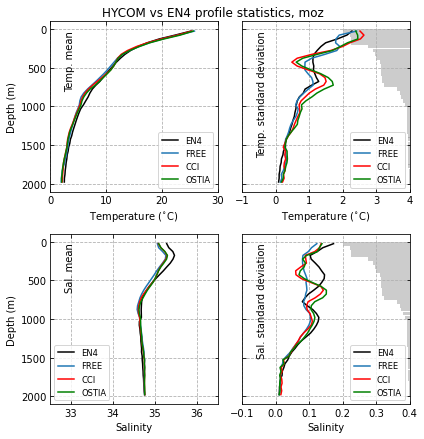

In [89]:
plotProfileStats('moz')

## Plotting MAD between experiments, compared to EN4

In [90]:
def plot_ProfileMAD(region):
    '''Plot MAD between available experients and EN4 for specified region.
    
    e.g. usage: plot_ProfileMAD('ben')
    
    Returns 2 vertical profile plots of each experiment's mean absolute difference
    against EN4. First plot is for temperature, second is for salinity.
    '''
    if region == 'moz':
        profs_free = moz_matched_free.copy()
        profs_cci = moz_matched_cci.copy()
        profs_ostia = moz_matched_ostia.copy()
#         profs_l2 = moz_matched_free.copy()
#         profs_l2l3 = moz_matched_free.copy()
    elif region == 'agu':
        profs_free = agu_matched_free.copy()
        profs_cci = agu_matched_cci.copy()
        profs_ostia = agu_matched_ostia.copy()
#         profs_l2 = moz_matched_free.copy()
#         profs_l2l3 = moz_matched_free.copy()
    elif region == 'ben':
        profs_free = ben_matched_free.copy()
        profs_cci = ben_matched_cci.copy()
        profs_ostia = ben_matched_ostia.copy()
#         profs_l2 = moz_matched_free.copy()
#         profs_l2l3 = moz_matched_free.copy()
    else:
        print("Unrecognised region, '{0}'. Quitting.".format(region))
        return
    
    # Create absolute differences between model and EN4
    # For FREE experiment
    profs_free['mad_temp'] = abs(profs_free['POTM_CORRECTED']
                                 - profs_free['temperature'])
    profs_free['mad_sal'] = abs(profs_free['PSAL_CORRECTED']
                                - profs_free['salinity'])
    # For CCI experiment
    profs_cci['mad_temp'] = abs(profs_cci['POTM_CORRECTED']
                                - profs_cci['temperature'])
    profs_cci['mad_sal'] = abs(profs_cci['PSAL_CORRECTED']
                               - profs_cci['salinity'])
    # For OSTIA experiment
    profs_ostia['mad_temp'] = abs(profs_ostia['POTM_CORRECTED']
                                  - profs_ostia['temperature'])
    profs_ostia['mad_sal'] = abs(profs_ostia['PSAL_CORRECTED']
                                 - profs_ostia['salinity'])
#     # For L2 experiment
#     profs_l2['mad_temp'] = abs(profs_l2['POTM_CORRECTED'] - profs_l2['temperature'])
#     profs_l2['mad_sal'] = abs(profs_l2['PSAL_CORRECTED'] - profs_l2['salinity'])
#     # For L2+L3 experiment
#     profs_l2l3['mad_temp'] = abs(profs_l2l3['POTM_CORRECTED'] - profs_l2l3['temperature'])
#     profs_l2l3['mad_sal'] = abs(profs_l2l3['PSAL_CORRECTED'] - profs_l2l3['salinity'])
    
    # Group data by depth intervals and mean values per bin
    binned_profs_free = profs_free.groupby(pd.cut(profs_free['DEPH_CORRECTED'],
                                                  np.arange(0, 2050, 50))).mean()
    binned_profs_cci = profs_cci.groupby(pd.cut(profs_cci['DEPH_CORRECTED'],
                                                np.arange(0, 2050, 50))).mean()
    binned_profs_ostia = profs_ostia.groupby(pd.cut(profs_ostia['DEPH_CORRECTED'],
                                                np.arange(0, 2050, 50))).mean()
#     binned_profs_l2 = profs_l2.groupby(pd.cut(profs_l2['DEPH_CORRECTED'],
#                                               np.arange(0, 2050, 50))).mean()
#     binned_profs_l2l3 = profs_l2l3.groupby(pd.cut(profs_l2l3['DEPH_CORRECTED'],
#                                                   np.arange(0, 2050, 50))).mean()
    
    #--------------------------------------------------------------------------------
    # Plotting the statistics
    fig, axs = plt.subplots(1, 2, figsize=(4.5,4), sharey=True)
    fig.suptitle('Mean Absolute Differences, {0}'.format(region), y=1.01)
    
    # Plotting temperature MAD
    axs[0].plot(binned_profs_free['mad_temp'],
                  binned_profs_free['DEPH_CORRECTED'], label='FREE')
    axs[0].plot(binned_profs_cci['mad_temp'],
                  binned_profs_cci['DEPH_CORRECTED'], label='CCI')
    axs[0].plot(binned_profs_ostia['mad_temp'],
                  binned_profs_ostia['DEPH_CORRECTED'], label='OSTIA')
#     axs[0].plot(binned_profs_l2['mad_temp'],
#                   binned_profs_l2['DEPH_CORRECTED'], label='L2')
#     axs[0].plot(binned_profs_l2l3['mad_temp'],
#                   binned_profs_l2l3['DEPH_CORRECTED'], label='L2+L3')
    axs[0].invert_yaxis()    # only call this once thoughout plotting script !!!
    axs[0].set_xlim(0,3)
    axs[0].grid(linestyle='--')
    axs[0].set_xlabel('Temperature ($^{\circ}$C)')
    axs[0].set_ylabel('Depth (m)')
#     axs[0].text(0.15, 0.95, 'Temp. mean', fontweight='roman',
#                   horizontalalignment='right', verticalalignment='top',
#                   rotation='vertical', transform=axs[0].transAxes)
    axs[0].legend(loc='lower right', fontsize='small')
#     axs[0].set_xticks(ticks=([0.0,0.5,1.0,1.5,2.0]))
    axs[0].tick_params(axis="both", direction='in', top=True, right=True)
    
    # Plotting salinity MAD
    axs[1].plot(binned_profs_free['mad_sal'],
                  binned_profs_free['DEPH_CORRECTED'], label='FREE')
    axs[1].plot(binned_profs_cci['mad_sal'],
                  binned_profs_cci['DEPH_CORRECTED'], label='CCI')
    axs[1].plot(binned_profs_ostia['mad_sal'],
                  binned_profs_ostia['DEPH_CORRECTED'], label='OSTIA')
#     axs[1].plot(binned_profs_l2['mad_sal'],
#                   binned_profs_l2['DEPH_CORRECTED'], label='L2')
#     axs[1].plot(binned_profs_l2l3['mad_sal'],
#                   binned_profs_l2l3['DEPH_CORRECTED'], label='L2+L3')
    axs[1].set_xlim(0,0.4)
    axs[1].grid(linestyle='--')
    axs[1].set_xlabel('Salinity')
    axs[1].set_ylabel('Depth (m)')
#     axs[1].text(0.15, 0.95, 'Temp. mean', fontweight='roman',
#                   horizontalalignment='right', verticalalignment='top',
#                   rotation='vertical', transform=axs[1].transAxes)
    axs[1].legend(loc='lower right', fontsize='small')
    axs[1].set_xticks(ticks=([0.0,0.1,0.2,0.3,0.4]))
    axs[1].tick_params(axis="both", direction='in', top=True, right=True)
    
    fig.tight_layout()
    plt.savefig('../Figures/profiles/EN4_profile_data/Profile_MAD_{0}_ROIv2.png'.format(region),
                dpi=300, bbox_inches='tight')

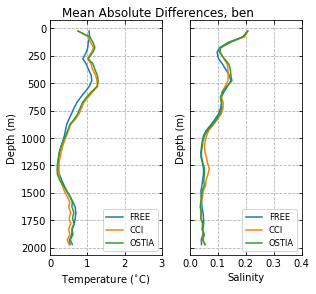

In [93]:
plot_ProfileMAD('ben')

In [146]:
binned_profs_count = agu_matched.groupby(pd.cut(agu_matched['DEPH_CORRECTED'], np.arange(0, 2050, 50))).count()
binned_profs_count

,N_PROF,N_LEVELS,LATITUDE,LONGITUDE,DEPH_CORRECTED,POTM_CORRECTED,PSAL_CORRECTED,PSAL_CORRECTED_QC,POTM_CORRECTED_QC,JULD,...,poly_id,wkt_right,depth,station,time,longitude,latitude,model_depth,salinity,temperature
DEPH_CORRECTED,,,,,,,,,,,,,,,,,,,,,
"(0, 50]",3857,3857,3857,3857,3857,3038,434,3857,3857,3857,...,3857,3857,3857,3857,3857,3857,3857,3857,3529,3529
"(50, 100]",3497,3497,3497,3497,3497,2972,402,3497,3497,3497,...,3497,3497,3497,3497,3497,3497,3497,3497,3172,3172
"(100, 150]",3665,3665,3665,3665,3665,3265,401,3665,3665,3665,...,3665,3665,3665,3665,3665,3665,3665,3665,3197,3197
"(150, 200]",3697,3697,3697,3697,3697,3276,401,3697,3697,3697,...,3697,3697,3697,3697,3697,3697,3697,3697,3224,3224
"(200, 250]",1531,1531,1531,1531,1531,1311,309,1531,1531,1531,...,1531,1531,1531,1531,1531,1531,1531,1531,1293,1293
"(250, 300]",481,481,481,481,481,433,301,481,481,481,...,481,481,481,481,481,481,481,481,434,434
"(300, 350]",465,465,465,465,465,416,278,465,465,465,...,465,465,465,465,465,465,465,465,404,404
"(350, 400]",453,453,453,453,453,380,251,453,453,453,...,453,453,453,453,453,453,453,453,382,382
"(400, 450]",400,400,400,400,400,320,198,400,400,400,...,400,400,400,400,400,400,400,400,336,336


In [15]:
# agu_matched.where(agu_matched['POTM_CORRECTED'] - agu_matched['temperature'] > 10)
# moz_matched.dropna(how='all', inplace=True)
agu_matched['diff_temp'] = abs(agu_matched['POTM_CORRECTED'] - agu_matched['temperature'])
agu_matched['diff_sal'] = abs(agu_matched['PSAL_CORRECTED'] - agu_matched['salinity'])
# agu_matched['mod_std_temp'] = np.std(agu_matched['POTM_CORRECTED'], axis=1)
# agu_matched['obs_std_temp']
# agu_matched['diff']
# agu_matched['mod_std_temp']

In [16]:
agu_dup = agu_matched
agu_dump_cut = agu_dup.groupby(pd.cut(agu_dup['DEPH_CORRECTED'], np.arange(0, 2025, 50))).mean()
agu_dump_cut

,N_PROF,N_LEVELS,LATITUDE,LONGITUDE,DEPH_CORRECTED,POTM_CORRECTED,PSAL_CORRECTED,PSAL_CORRECTED_QC,POTM_CORRECTED_QC,index_right,poly_id,depth,station,longitude,latitude,model_depth,salinity,temperature,diff_temp,diff_sal
DEPH_CORRECTED,,,,,,,,,,,,,,,,,,,,
"(0, 50]",173317.380866,36.721805,-30.196917,31.164290,23.308783,22.704174,35.475191,3.662432,1.637024,0.0,1.0,23.308783,1.0,31.165098,-30.197334,858.956482,35.163139,23.324118,1.225692,0.270303
"(50, 100]",172874.425794,107.308264,-30.192026,31.178678,75.468010,19.701277,35.447889,3.655133,1.450386,0.0,1.0,75.468010,1.0,31.179525,-30.192448,877.618652,35.200638,19.384388,1.364246,0.232600
"(100, 150]",173480.668486,177.181173,-30.172120,31.201999,125.166513,17.435508,35.466139,3.671760,1.327422,0.0,1.0,125.166513,1.0,31.202847,-30.172550,867.479675,35.206593,16.637678,1.861788,0.255649
"(150, 200]",173455.614823,248.866378,-30.169540,31.204297,175.103508,16.039211,35.431698,3.674601,1.341628,0.0,1.0,175.103508,1.0,31.205151,-30.169970,864.564941,35.139458,14.541485,2.237972,0.287931
"(200, 250]",132780.941215,283.817113,-30.302325,31.073821,217.881150,15.084300,35.347425,3.394513,1.431091,0.0,1.0,217.881150,1.0,31.075024,-30.302502,963.270508,35.075775,13.088394,2.299883,0.282378
"(250, 300]",131483.222453,193.985447,-31.537423,29.834599,275.419402,14.391125,35.298240,2.122661,1.299376,0.0,1.0,275.419403,1.0,29.834782,-31.537109,1891.721802,35.043701,12.520874,2.044924,0.286911
"(300, 350]",134119.221505,212.206452,-31.406032,30.004596,325.290126,13.471075,35.210053,2.206452,1.316129,0.0,1.0,325.290126,1.0,30.004730,-31.405764,1823.915405,34.988693,11.885463,1.806312,0.268076
"(350, 400]",138012.298013,225.582781,-31.392465,30.010033,375.026042,12.978228,35.159023,2.337748,1.483444,0.0,1.0,375.026042,1.0,30.010221,-31.392097,1829.701538,34.939468,11.343151,1.697245,0.244420
"(400, 450]",137116.605000,248.360000,-31.084588,30.437566,425.630982,12.281706,35.089797,2.515000,1.600000,0.0,1.0,425.630982,1.0,30.437824,-31.084126,1721.747925,34.890205,10.811734,1.344902,0.194635


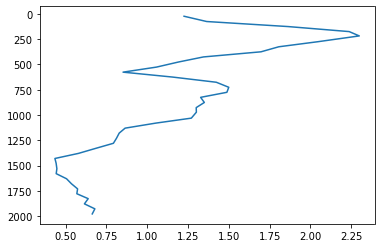

In [16]:
plt.plot(agu_dump_cut['diff_temp'],agu_dump_cut['DEPH_CORRECTED'])
plt.gca().invert_yaxis()

In [17]:
# agu_dup_corr = agu_dup.groupby(pd.cut(agu_dup['DEPH_CORRECTED'], np.arange(0, 2025, 50))).std()
agu_dup_corr2 = agu_dup.groupby(pd.cut(agu_dup['DEPH_CORRECTED'], np.arange(0, 2025, 50)))[['POTM_CORRECTED','temperature']].corr().iloc[0::2,-1]

In [20]:
# agu_dup_corr['temperature']
agu_dup_corr2

DEPH_CORRECTED                
(0, 50]         POTM_CORRECTED    0.798335
(50, 100]       POTM_CORRECTED    0.754722
(100, 150]      POTM_CORRECTED    0.723205
(150, 200]      POTM_CORRECTED    0.741615
(200, 250]      POTM_CORRECTED    0.695438
(250, 300]      POTM_CORRECTED    0.560235
(300, 350]      POTM_CORRECTED    0.558396
(350, 400]      POTM_CORRECTED    0.561624
(400, 450]      POTM_CORRECTED    0.609801
(450, 500]      POTM_CORRECTED    0.613954
(500, 550]      POTM_CORRECTED    0.616411
(550, 600]      POTM_CORRECTED    0.674190
(600, 650]      POTM_CORRECTED    0.468385
(650, 700]      POTM_CORRECTED    0.454151
(700, 750]      POTM_CORRECTED    0.467720
(750, 800]      POTM_CORRECTED    0.464604
(800, 850]      POTM_CORRECTED    0.534390
(850, 900]      POTM_CORRECTED    0.466362
(900, 950]      POTM_CORRECTED    0.451712
(950, 1000]     POTM_CORRECTED    0.393415
(1000, 1050]    POTM_CORRECTED    0.302536
(1050, 1100]    POTM_CORRECTED    0.325240
(1100, 1150]    POTM_CO

In [22]:
agu_dump_cut['corr_test'] = agu_dup_corr2.values

In [23]:
agu_dump_cut

,N_PROF,N_LEVELS,LATITUDE,LONGITUDE,DEPH_CORRECTED,POTM_CORRECTED,PSAL_CORRECTED,PSAL_CORRECTED_QC,POTM_CORRECTED_QC,index_right,...,depth,station,longitude,latitude,model_depth,salinity,temperature,diff_temp,diff_sal,corr_test
DEPH_CORRECTED,,,,,,,,,,,,,,,,,,,,,
"(0, 50]",173317.380866,36.721805,-30.196917,31.164290,23.308783,22.704174,35.475191,3.662432,1.637024,0.0,...,23.308783,1.0,31.165098,-30.197334,858.956482,35.163139,23.324118,1.225692,0.270303,0.798335
"(50, 100]",172874.425794,107.308264,-30.192026,31.178678,75.468010,19.701277,35.447889,3.655133,1.450386,0.0,...,75.468010,1.0,31.179525,-30.192448,877.618652,35.200638,19.384388,1.364246,0.232600,0.754722
"(100, 150]",173480.668486,177.181173,-30.172120,31.201999,125.166513,17.435508,35.466139,3.671760,1.327422,0.0,...,125.166513,1.0,31.202847,-30.172550,867.479675,35.206593,16.637678,1.861788,0.255649,0.723205
"(150, 200]",173455.614823,248.866378,-30.169540,31.204297,175.103508,16.039211,35.431698,3.674601,1.341628,0.0,...,175.103508,1.0,31.205151,-30.169970,864.564941,35.139458,14.541485,2.237972,0.287931,0.741615
"(200, 250]",132780.941215,283.817113,-30.302325,31.073821,217.881150,15.084300,35.347425,3.394513,1.431091,0.0,...,217.881150,1.0,31.075024,-30.302502,963.270508,35.075775,13.088394,2.299883,0.282378,0.695438
"(250, 300]",131483.222453,193.985447,-31.537423,29.834599,275.419402,14.391125,35.298240,2.122661,1.299376,0.0,...,275.419403,1.0,29.834782,-31.537109,1891.721802,35.043701,12.520874,2.044924,0.286911,0.560235
"(300, 350]",134119.221505,212.206452,-31.406032,30.004596,325.290126,13.471075,35.210053,2.206452,1.316129,0.0,...,325.290126,1.0,30.004730,-31.405764,1823.915405,34.988693,11.885463,1.806312,0.268076,0.558396
"(350, 400]",138012.298013,225.582781,-31.392465,30.010033,375.026042,12.978228,35.159023,2.337748,1.483444,0.0,...,375.026042,1.0,30.010221,-31.392097,1829.701538,34.939468,11.343151,1.697245,0.244420,0.561624
"(400, 450]",137116.605000,248.360000,-31.084588,30.437566,425.630982,12.281706,35.089797,2.515000,1.600000,0.0,...,425.630982,1.0,30.437824,-31.084126,1721.747925,34.890205,10.811734,1.344902,0.194635,0.609801


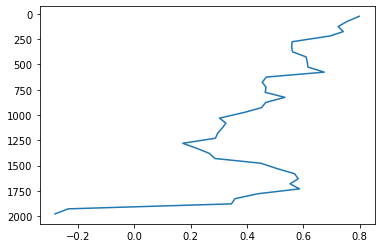

In [62]:
# roll_corr = agu_sorted['POTM_CORRECTED'].rolling(20).corr(agu_sorted['temperature'])
# roll_corr = agu_sorted['POTM_CORRECTED'].rolling(10).mean()
# roll_depth = agu_sorted['DEPH_CORRECTED'].rolling(10).mean()

plt.plot(agu_dup_corr2,agu_dump_cut['DEPH_CORRECTED'])
plt.gca().invert_yaxis()

In [18]:
agu_sorted = agu_matched.sort_values(by=['DEPH_CORRECTED'])
agu_sorted

,N_PROF,N_LEVELS,LATITUDE,LONGITUDE,DEPH_CORRECTED,POTM_CORRECTED,PSAL_CORRECTED,PSAL_CORRECTED_QC,POTM_CORRECTED_QC,JULD,...,depth,station,time,longitude,latitude,model_depth,salinity,temperature,diff_temp,diff_sal
0,93669,0,-31.3330,30.7770,0.00,25.564900,35.5123,1,1,2009-03-25 05:01:48.000000,...,0.000000,1,2009-03-25,30.780001,-31.330000,3005.519775,35.212433,25.988798,0.423898,0.299867
0,93664,0,-31.1780,30.6320,0.00,25.956400,35.5591,1,1,2009-03-25 00:04:01.200019,...,0.000000,1,2009-03-25,30.629999,-31.180000,2671.267822,35.226856,26.004166,0.047766,0.332244
0,93602,0,-33.3619,28.1850,0.00,25.705700,NaN,4,1,2009-03-23 02:03:00.000002,...,0.000000,1,2009-03-23,28.180000,-33.360001,1136.609131,35.152687,23.901993,1.803707,NaN
0,93634,0,-31.0580,30.3670,0.00,26.135000,35.4663,1,1,2009-03-24 03:01:48.000017,...,0.000000,1,2009-03-24,30.370001,-31.059999,1663.475586,35.188400,26.339025,0.204025,0.277900
0,93656,0,-31.1450,30.5370,0.00,26.050000,35.5500,1,1,2009-03-24 19:36:00.000018,...,0.000000,1,2009-03-24,30.540001,-31.139999,2353.041748,35.199387,25.810045,0.239955,0.350613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,93669,393,-31.3330,30.7770,2881.80,1.902959,34.8116,1,1,2009-03-25 05:01:48.000000,...,2881.800049,1,2009-03-25,30.780001,-31.330000,3005.519775,34.777721,1.240746,0.662214,0.033879
35,105627,35,-31.4938,30.9750,2898.71,1.893524,34.8120,1,1,2009-03-25 11:25:12.000019,...,2898.709961,1,2009-03-25,30.980000,-31.490000,2998.041016,34.776348,1.269054,0.624470,0.035652
396,93673,396,-31.4870,30.9830,2899.40,1.895620,34.8095,1,1,2009-03-25 10:24:00.000000,...,2899.399902,1,2009-03-25,30.980000,-31.490000,2998.041016,34.776348,1.268246,0.627375,0.033152
35,105620,35,-31.3498,30.7575,2932.24,1.772203,34.8040,1,1,2009-03-25 06:09:00.000008,...,2932.239990,1,2009-03-25,30.760000,-31.350000,3005.519775,34.778408,1.232656,0.539547,0.025592
